In [75]:
# start step-by step
from skimage import io, feature, filters
import skimage
from skimage.morphology import disk 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, precision_score, recall_score, roc_auc_score

sns.set_context('poster')
sns.set_style('white')
%matplotlib inline

In [16]:
# read the raw data and the binary classification (test data)
raw = io.imread('data/raw-49.tif')
cells = io.imread('data/binary-49.tif')
bg = np.invert(cells)

(555, 380)
(555, 380)


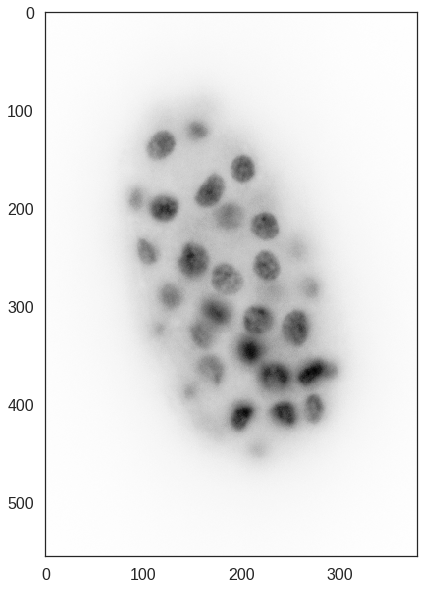

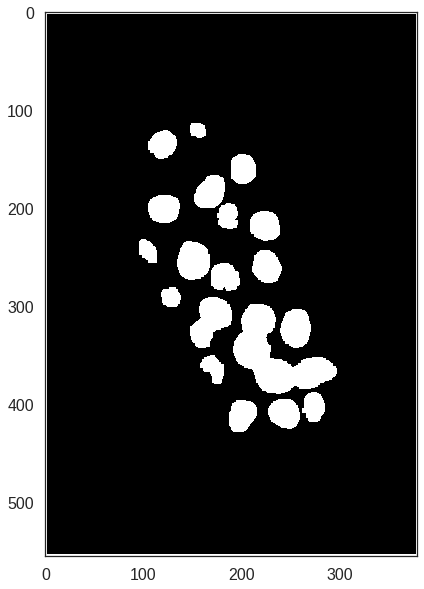

In [56]:
print(raw.shape)
plt.figure(figsize=(20,10))
plt.imshow(raw)

print(cells.shape)
plt.figure(figsize=(20,10))
plt.imshow(cells)

# print(bg.shape)
# plt.figure(figsize=(20,10))
# plt.imshow(bg)

In [84]:
# get the features
f_sobel = filters.sobel(raw)
sigma = 3.0
f_gauss = filters.gaussian(raw, sigma)
f_hessian = filters.hessian(raw)
# f_median = filters.median(raw, disk(sigma))
f_laplacian = filters.laplace(raw) 
f_gabor = filters.gabor(raw, frequency=sigma) # might be slow 

In [86]:
def generate_features():
    f = 1.0

In [19]:
# check which values correspond to cell
np.unique(cells)

array([  0, 255], dtype=uint8)

In [32]:
y = np.array([p==0 for p in cells.flatten()])
# y = cells.flatten()
X = np.vstack([f_sobel.flatten(), f_gauss.flatten(), f_hessian.flatten()]).T
y.shape, X.shape

((210900,), (210900, 3))

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X.shape, X_train.shape, X_test.shape

((210900, 3), (141303, 3), (69597, 3))

In [34]:
%%time
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

CPU times: user 1.12 s, sys: 4 ms, total: 1.13 s
Wall time: 1.13 s


In [35]:
y_hat = clf.predict(X_test)
print(classification_report(y_test, y_hat))

             precision    recall  f1-score   support

      False       0.97      1.00      0.99     62909
       True       0.96      0.76      0.85      6688

avg / total       0.97      0.97      0.97     69597



In [40]:
skf = StratifiedKFold(y, 5)
precision_scores = list()
recall_scores = list()
aucs = list()
for train_ix, test_ix in skf: # for each of K folds
    # define training and test sets
    X_train, X_test = X[train_ix,:], X[test_ix,:]
    y_train, y_test = y[train_ix], y[test_ix]
    
    # Train classifier
    clf = RandomForestClassifier(n_jobs=2)
    clf.fit(X_train, y_train)
    
    # Predict test set labels
    yhat = clf.predict(X_test)
    yprob = clf.predict_proba(X_test)
    
    # Calculate metrics
    aucs.append(roc_auc_score(y_test, yprob[:,1]))
    precision_scores.append(precision_score(y_test, yhat))
    recall_scores.append(recall_score(y_test, yhat))

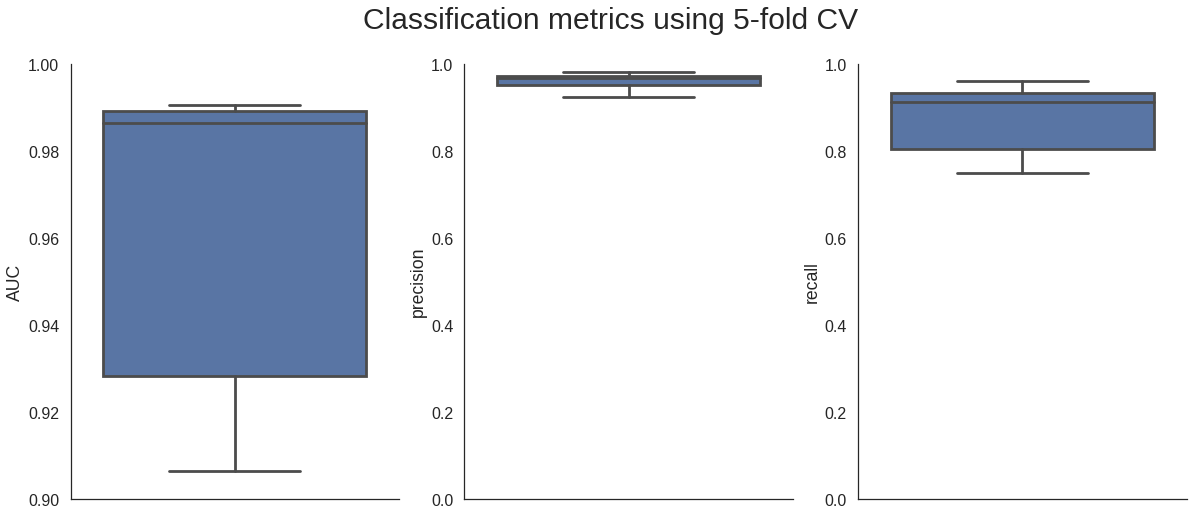

In [41]:
plt.figure(figsize=(20,8))
plt.subplot(131)
sns.boxplot(aucs, orient='v')
plt.ylim(.9,1)
plt.ylabel("AUC")

plt.subplot(132)
sns.boxplot(precision_scores, orient='v')
plt.ylim(0,1)
plt.ylabel("precision")

plt.subplot(133)
sns.boxplot(recall_scores, orient='v')
plt.ylim(0,1)
plt.ylabel("recall")
sns.despine()

plt.suptitle("Classification metrics using 5-fold CV", fontsize=30)

In [42]:
print(yprob, yprob.size)

[[ 0.19933968  0.80066032]
 [ 0.29529277  0.70470723]
 [ 0.20968041  0.79031959]
 ..., 
 [ 0.29133692  0.70866308]
 [ 0.29133692  0.70866308]
 [ 0.29133692  0.70866308]] 84358


In [63]:
# prepare run on the real data
raw_real = io.imread('data/raw-85.tif')


# calculate the features manually
f_sobel_real = filters.sobel(raw_real)
sigma = 3.0
f_gauss_real = filters.gaussian(raw_real, sigma)
f_hessian_real = filters.hessian(raw_real)

X_real = np.vstack([f_sobel_real.flatten(), f_gauss_real.flatten(), f_hessian_real.flatten()]).T

raw_real_predicted = clf.predict(X_real)
raw_real_predicted_proba = clf.predict_proba(X_real)

In [68]:
raw_real_predicted_proba.shape, raw_real_predicted.shape

((298896, 2), (298896,))

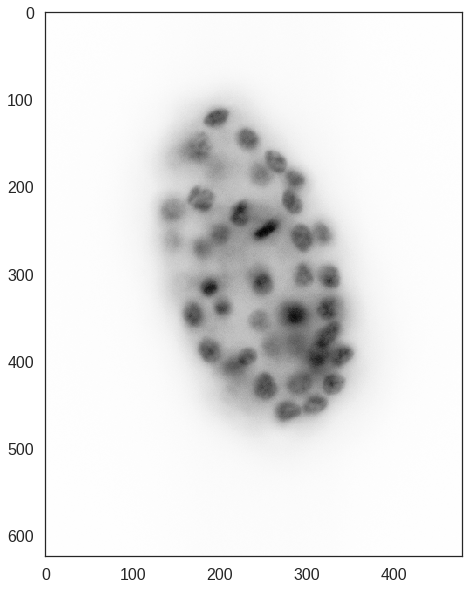

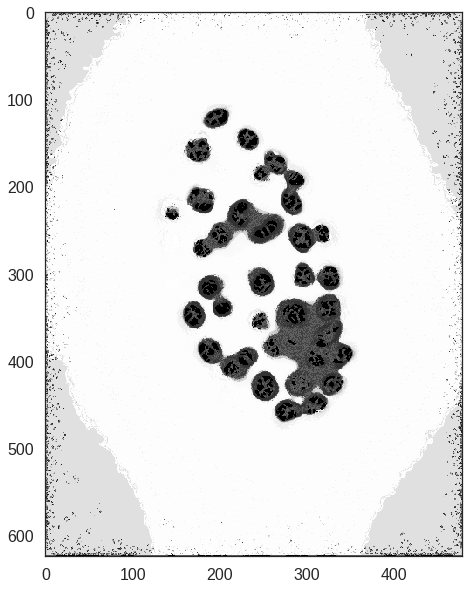

In [72]:
result = np.reshape(raw_real_predicted, raw_real.shape)
result_proba = np.reshape(raw_real_predicted_proba[:, 1], raw_real.shape)

plt.figure(figsize=(20,10))
plt.imshow(raw_real)

plt.figure(figsize=(20,10))
plt.imshow(result_proba)

# plt.figure(figsize=(20,10))
# plt.imshow(result)